In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from plotting_fxns import *

In [3]:
glacier = 'Gulkana'
id = '0'
date = str(pd.Timestamp.today()).replace('-','_')[0:10]
data_fp = f'/home/claire/research/Output/EB/{glacier}_{date}_#.nc'
ds,startdate,enddate = getds(data_fp.replace('#',id))
# base_fp = f'/home/claire/research/Output/EB/Gulkana_2024_05_07_3.nc'
# base_ds,_,_ = getds(base_fp)
stake_df = pd.read_csv('~/research/MB_data/Stakes/gulkanaAB23_ALL.csv')
stake_df.index = pd.to_datetime(stake_df['Date'])
temp_df = pd.read_csv('~/research/MB_data/Gulkana/field_data/iButton_2023_all.csv',index_col=0)
temp_df = temp_df.set_index(pd.to_datetime(temp_df.index) - pd.Timedelta(hours=8))

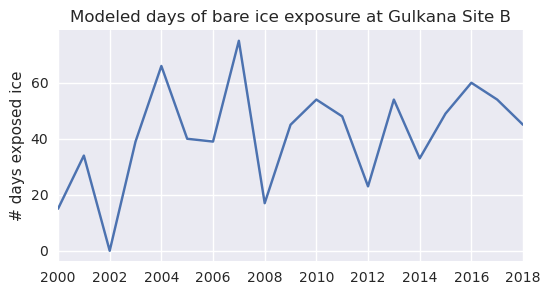

In [14]:
store = []
fig,ax = plt.subplots(figsize=(6,3))
for year in range(2000,2019):
    start = pd.to_datetime(str(year)+'-06-15 00:30')
    end = pd.to_datetime(str(year)+'-10-30 00:30')
    dates = pd.date_range(start,end,freq='h')
    density = ds.layerdensity.sel(time=dates,bin=0).resample(time='d').mean()
    ice_days = density.sel(layer=0).values > 700
    store.append(sum(ice_days))
ax.plot(np.arange(2000,2019),store)
ax.set_ylabel('# days exposed ice')
ax.set_xticks(np.arange(2000,2019,2).astype(int))
ax.set_xlim(2000,2018)
ax.set_title('Modeled days of bare ice exposure at Gulkana Site B')
plt.show()

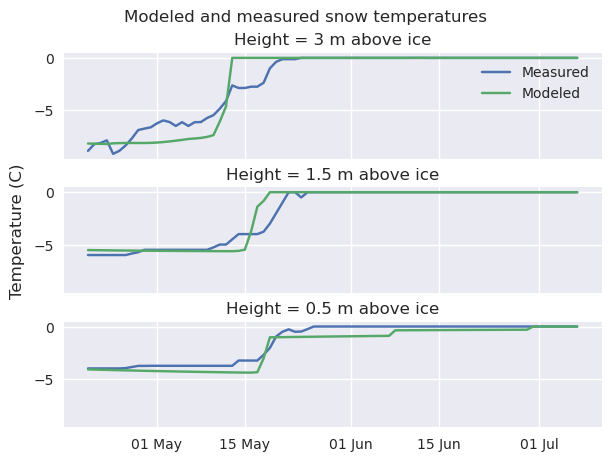

In [106]:
ds_,_,_ = getds(data_fp.replace('#','12'))
temp_vs_iButton(ds_,temp_df,pd.date_range(startdate,'2023-07-08'),0,[3,1.5,0.5])
plt.savefig('/home/claire/research/snowtemps.png',dpi=200)

<xarray.DataArray 'albedo' ()>
array(0.58218163)
Coordinates:
    bin      int64 0
<xarray.DataArray 'albedo' ()>
array(0.63856353)
Coordinates:
    bin      int64 0


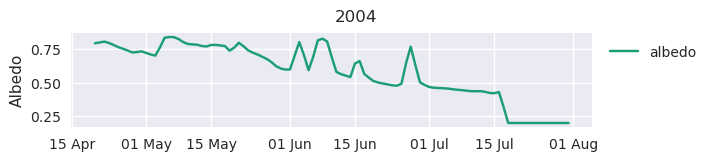

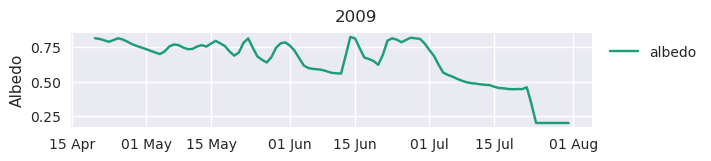

In [15]:
simple_plot(ds,0,['2003-04-20 00:30','2003-07-31 00:30'],[['albedo']],t='2004')
simple_plot(ds,0,['2009-04-20 00:30','2009-07-31 00:30'],[['albedo']],t='2009')

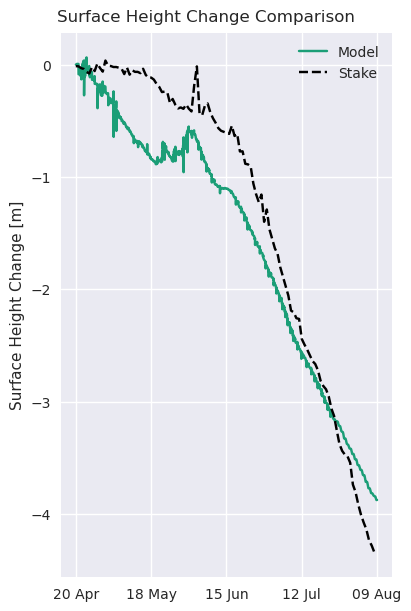

In [107]:
ds,_,enddate = getds(data_fp.replace('#','3'))
dh_vs_stake(stake_df,[ds],[startdate,enddate])
plt.savefig('/home/claire/research/mb_2023.png',dpi=200)

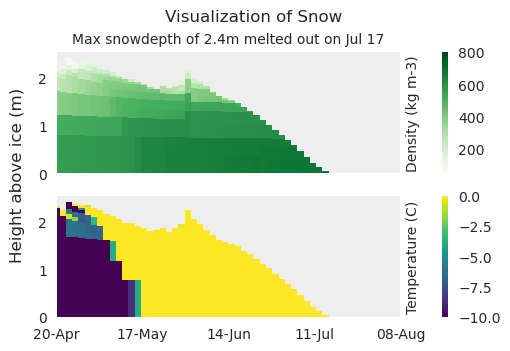

In [71]:
visualize_layers(ds,0,pd.date_range(startdate,enddate,freq='2d'),['layerdensity','layertemp'])

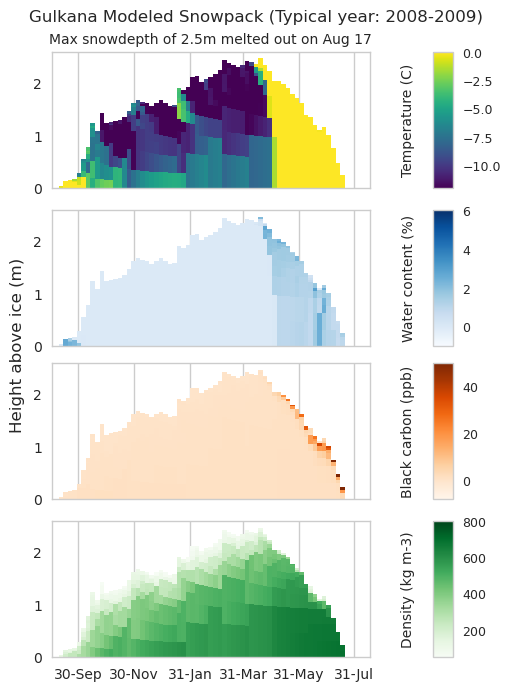

In [45]:
# ds,startdate,enddate = getds(data_fp.replace('#','1'))
start = pd.to_datetime('2008-09-01 00:30')
end = pd.to_datetime('2009-08-20 00:30') 
visualize_layers(ds,0,pd.date_range(start,end,freq='5d'),['layertemp','layerwater','layerBC','layerdensity'],t='Gulkana Modeled Snowpack (Typical year: 2008-2009)')

# visualize_layers(ds,0,pd.date_range(start,end,freq='3d'),['layertemp','layerwater','layerBC','layerdensity'],t='Gulkana Modeled Snowpack (Heatwave year: 2003-2004)')

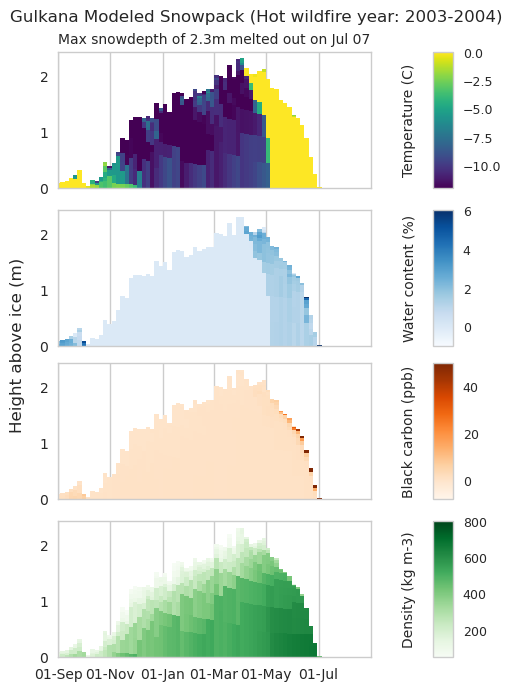

In [52]:
start = pd.to_datetime('2003-09-01 00:30')
end = pd.to_datetime('2004-09-02 00:30')
visualize_layers(ds,0,pd.date_range(start,end,freq='5d'),['layertemp','layerwater','layerBC','layerdensity'],t='Gulkana Modeled Snowpack (Hot wildfire year: 2003-2004)')

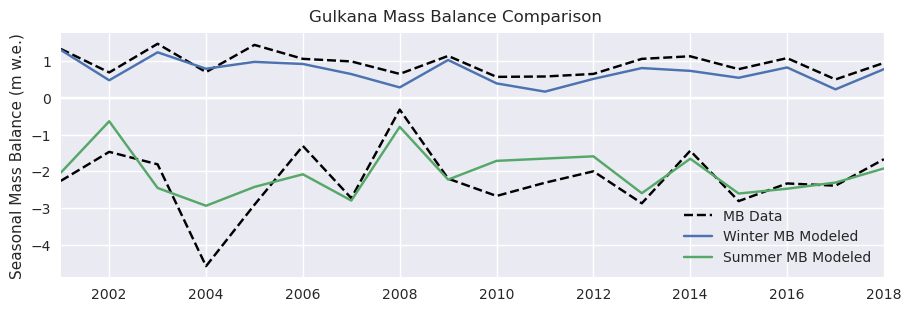

In [108]:
ds,startdate,enddate = getds('~/research/Output/EB/Gulkana_2024_05_28_1.nc')
mb_fp = '/home/claire/research/MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv'
ds_list = [ds]
years = np.arange(2001,2019)
site = 'B'
mb_df = pd.read_csv(mb_fp)
# start func
fig,ax = plt.subplots(figsize=(9,3),sharex=True,layout='constrained')
mb_df = mb_df.loc[mb_df['site_name'] == site]
mb_df.index = mb_df['Year']

# plot mass balance data
winter_mb_data = mb_df['bw'].loc[mb_df['Year'].isin(years)]
summer_mb_data = mb_df['ba'].loc[mb_df['Year'].isin(years)] - mb_df['bw'].loc[mb_df['Year'].isin(years)]
ax.plot(years,winter_mb_data,label='MB Data',color='black',linestyle='--')
ax.plot(years,summer_mb_data,color='black',linestyle='--')

mb_mod = {'bw':[],'bs':[]}
for ds in ds_list:
    for year in years:
        # spring_date = mb_df['spring_date'].loc[year]
        # fall_date = mb_df['fall_date'].loc[year]
        # next_spring_date = mb_df
        spring_date = str(year)+'-04-20 00:00'
        fall_date = str(year)+'-08-20 00:00'
        next_spring_date = str(year)+'-04-20 00:00'
        last_fall_date = str(year-1)+'-08-20 00:00'
        melt_dates = pd.date_range(spring_date,fall_date,freq='h')
        acc_dates = pd.date_range(last_fall_date,spring_date,freq='h')
        if pd.to_datetime(ds.time.values[0]).minute == 30:
            melt_dates = melt_dates + pd.Timedelta(minutes=30)
            acc_dates = acc_dates + pd.Timedelta(minutes=30)
        # sum mass balance
        wds = ds.sel(time=acc_dates).sum()
        sds = ds.sel(time=melt_dates).sum()
        winter_mb = wds.accum + wds.refreeze - wds.melt
        summer_mb = sds.accum + sds.refreeze - sds.melt
        mb_mod['bw'].append(winter_mb.to_numpy())
        mb_mod['bs'].append(summer_mb.to_numpy())
    ax.plot(years,mb_mod['bw'],label='Winter MB Modeled')
    ax.plot(years,mb_mod['bs'],label='Summer MB Modeled')
ax.legend()
ax.axhline(0,color='white')
ax.set_ylabel('Seasonal Mass Balance (m w.e.)')
ax.set_xlim(2001,2018)
ax.set_xticks(np.arange(2002,2020,2))
fig.suptitle('Gulkana Mass Balance Comparison')
# plt.show()
plt.savefig('/home/claire/research/20yrfig.png',dpi=200)

/home/claire/miniconda3/envs/eb_env/lib/python3.11/site-packages/xarray/core/groupby.py:534: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(
/home/claire/miniconda3/envs/eb_env/lib/python3.11/site-packages/xarray/core/groupby.py:534: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(
/home/claire/miniconda3/envs/eb_env/lib/python3.11/site-packages/xarray/core/groupby.py:534: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(
/home/claire/miniconda3/envs/eb_env/lib/python3.11/site-packages/xarray/core/groupby.py:534: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


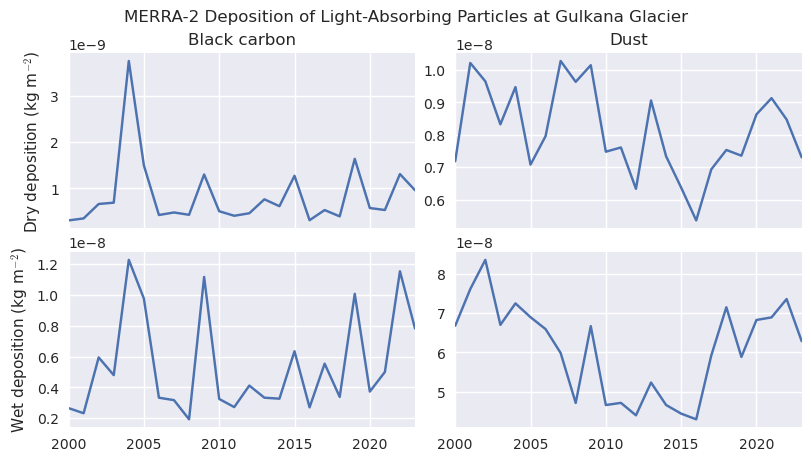

In [133]:
bcd = xr.open_dataarray('/home/claire/research/climate_data/MERRA2/BCDP002/MERRA2_BCDP002_60_-150.nc').sel(lat=63.5,lon=-145.625)*2.08
bcw = xr.open_dataarray('/home/claire/research/climate_data/MERRA2/BCWT002/MERRA2_BCWT002_60_-150.nc').sel(lat=63.5,lon=-145.625)
dud = xr.open_dataarray('/home/claire/research/climate_data/MERRA2/DUDP003/MERRA2_DUDP003_60_-150.nc').sel(lat=63.5,lon=-145.625)*3
duw = xr.open_dataarray('/home/claire/research/climate_data/MERRA2/DUWT003/MERRA2_DUWT003_60_-150.nc').sel(lat=63.5,lon=-145.625)*3
dslist = [bcd,dud,bcw,duw]
varlist = ['BCDP002','DUDP003','BCWT002','DUWT003']
labels = ['Dry BC','Dry Dust','Wet BC','Wet Dust']
fig,axes = plt.subplots(2,2,figsize=(8,4.5),layout='constrained',sharex=True)
axes = axes.flatten()
for i,ds in enumerate(dslist):
    var = varlist[i]
    ax = axes[i]
    ds = ds.resample(time='A').sum()
    ax.plot(np.arange(2000,2024),ds.values)
    ax.set_xlim(2000,2023)
    # ax.grid(False)
axes[0].set_ylabel('Dry deposition (kg m$^{-2}$)')
axes[2].set_ylabel('Wet deposition (kg m$^{-2}$)')
axes[0].set_title('Black carbon')
axes[1].set_title('Dust')
fig.suptitle('MERRA-2 Deposition of Light-Absorbing Particles at Gulkana Glacier')
plt.savefig('/home/claire/research/dep.png',dpi=200)

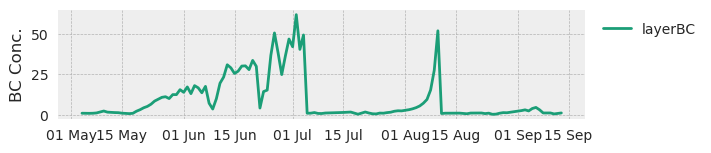

In [15]:
simple_plot(ds,0,[startdate,enddate],[['layerBC']])

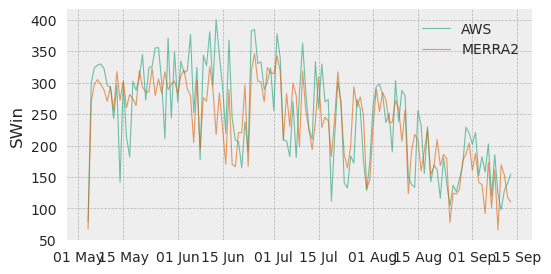

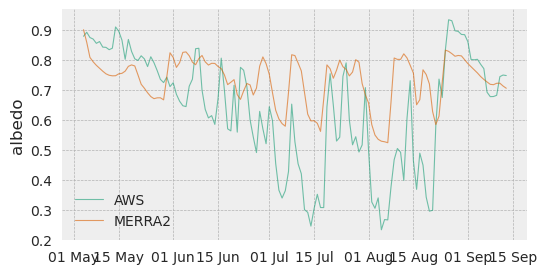

In [68]:
dsa,startdate,enddate = getds(data_fp.replace('#','0'))
dsm,_,_ = getds(data_fp.replace('#','1'))
#getds('/home/claire/research/Output/EB/South_2023_10_02_0.nc')
# simple_plot(dsold,0,[startdate,enddate],[['SW']])
compare_runs([dsa,dsm],[startdate,enddate],['AWS','MERRA2'],'SWin')
compare_runs([dsa,dsm],[startdate,enddate],['AWS','MERRA2'],'albedo')
# compare_runs([ds,dsold],[startdate,enddate],['new','old'],'meltenergy')

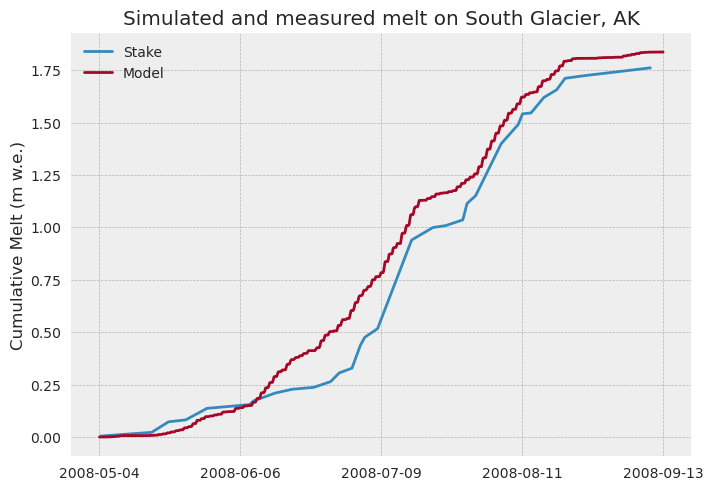

In [65]:
ds,startdate,enddate = getds(data_fp.replace('#','12'))
df = pd.read_csv('/home/claire/research/MB_data/South/stakes.csv',index_col=0)
df.index = pd.to_datetime(df.index)
# start = pd.to_datetime('2008-07-22 00:30')
# df = df.loc[start:] - 1.02
# ds = ds.sel(time=pd.date_range(start,enddate,freq='h'))
plt.plot(df.index,df['Melt'],label='Stake')
# ds = ds.resample(time='d').sum()
plt.plot(ds.coords['time'],ds['melt'].cumsum(),label='Model')

# plt.plot(ds_MERRA.coords['time'],ds_MERRA['melt'].cumsum(),label='Model (MERRA)')
# plt.plot(ds_AWS.coords['time'],ds_AWS['melt'].cumsum(),label='Model (AWS)')
plt.ylabel('Cumulative Melt (m w.e.)')
plt.xticks(pd.date_range(startdate,enddate,periods=5))
plt.title('Simulated and measured melt on South Glacier, AK')
plt.legend()

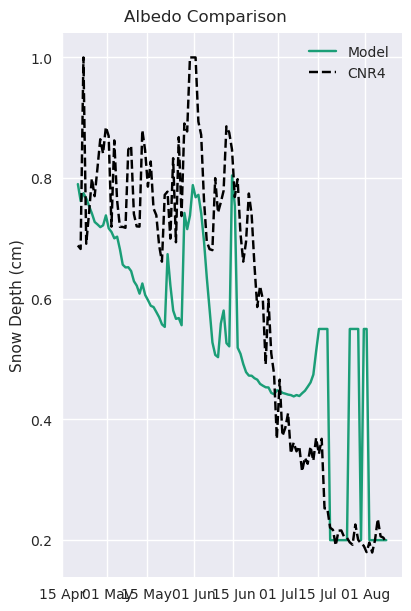

In [41]:
cnr4_df = pd.read_csv('/home/claire/research/climate_data/AWS/Gulkana/4_17-8_10_2023.CSV')
cnr4_df = cnr4_df.set_index(pd.to_datetime(cnr4_df['Datetime']))
albedo_vs_CNR4(cnr4_df,[ds],[startdate,enddate])

This notebook is intended to make plotting of the PyGEM-EB output straightforward for fast diagnostics after a model run. Most functions just need the information for the model run in the cell below. 

Specify the plotting style to use and the figure name to save the plot.

Run the following cells to plot the data. For information on any of the plotting functions, run 'help(name_of_function)'. Available functions are:
- simple_plot
- plot_AWS
- plot_stake_data
- compare_runs
- stacked_eb_barplot

In [9]:
labels = []
params = {
    'kp':[0.5,0.8],
    'albedo_ice':[0.1,0.3],
    'k_ice':[1,4],
    'ksp_BC':[0.01,0.8]
}
for kp in params['kp']:
    for aice in params['albedo_ice']:
        for ksp in params['ksp_BC']:
            for k_ice in params['k_ice']:
                labels.append(f'kp: {kp}, a_ice: {aice}, ksp_BC: {ksp}, k_ice: {k_ice}')
stake_df = pd.read_csv('~/research/MB_data/Stakes/gulkanaAB23_ALL.csv')
stake_df.index = pd.to_datetime(stake_df['Date'])

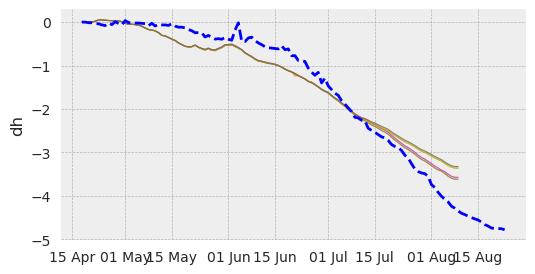

In [11]:
dslist = []
for i in range(0,8):
    fp = f'/home/claire/research/Output/EB/Gulkana_cal{i}.nc'
    ds,startdate,enddate = getds(fp)
    dslist.append(ds)
compare_runs(dslist,[startdate,enddate],labels,'dh')

plt.plot(stake_df.index,stake_df['CMB'],'b--')
plt.show()

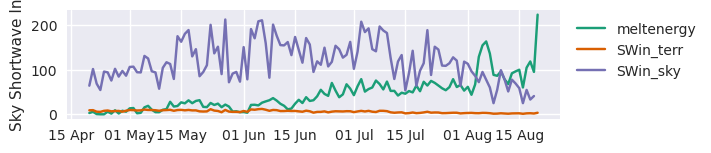

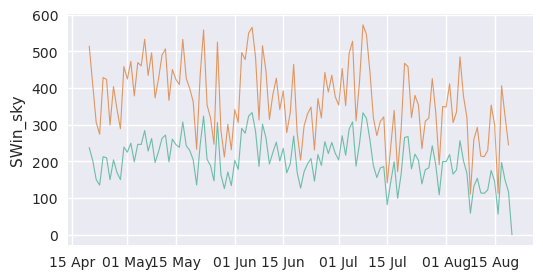

In [6]:
# ds_base,startdate,enddate = getds('/home/claire/research/Output/EB/Gulkana_2024_03_13_BASE.nc')
ds_test,startdate,enddate = getds('/home/claire/research/Output/EB/Gulkana_2024_03_29_4.nc')
simple_plot(ds_test,0,[startdate,enddate],[['meltenergy','SWin_terr','SWin_sky']])
ds_no,_,_ = getds('/home/claire/research/Output/EB/Gulkana_2024_03_29_17.nc')
ds_new,_,_ = getds('/home/claire/research/Output/EB/Gulkana_2024_03_29_29.nc')
compare_runs([ds_no,ds_new],[startdate,enddate],['no diffuse','with'],'SWin_sky')

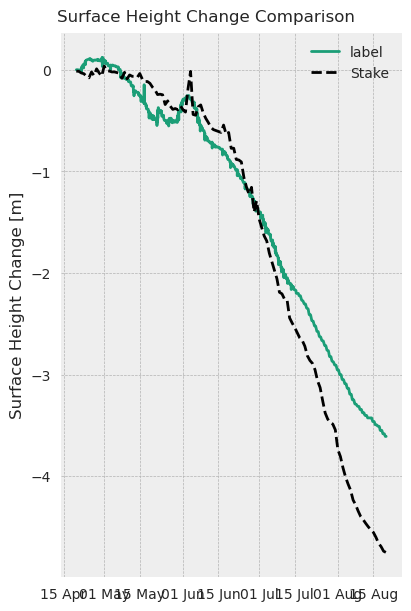

In [7]:
plot_stake_dh(stake_df,[ds_new],[startdate,enddate],['label'])

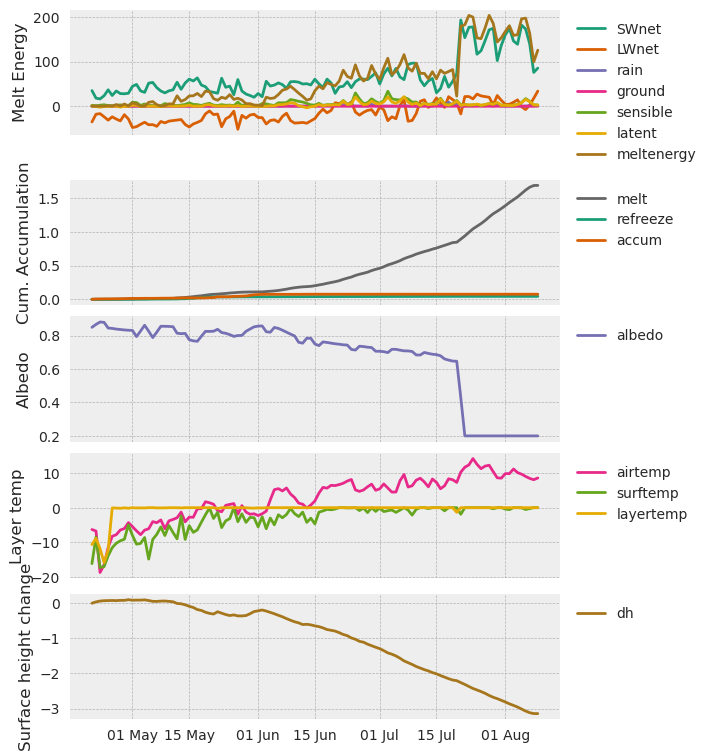

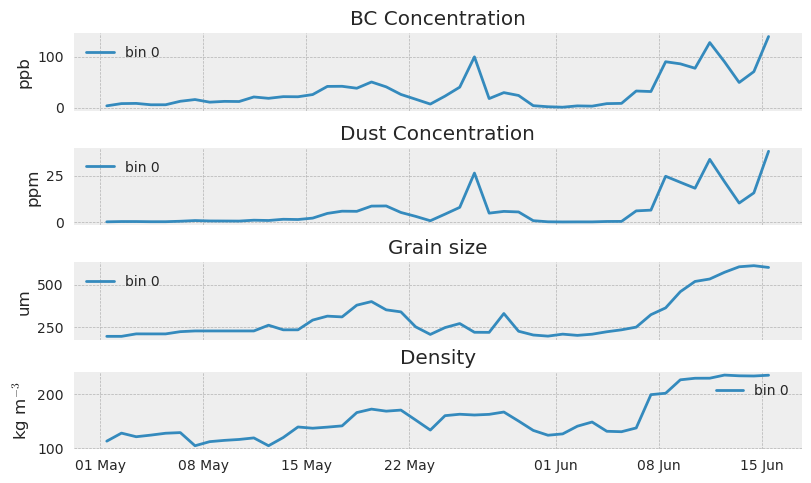

In [35]:
# from plotting_fxns import *
ds,startdate,enddate = getds('~/research/Output/EB/Gulkana_2024_03_13_BASE.nc') # 3_08_1
stake_df = pd.read_csv('~/research/MB_data/Stakes/gulkanaAB23_ALL.csv')
stake_df = stake_df.set_index(pd.to_datetime(stake_df['Date']))
# plot_stake_dh(stake_df,[ds],[startdate,enddate],['ds'])
dates = pd.date_range(startdate,enddate,freq='3d')
all = [['SWnet','LWnet','rain','ground','sensible','latent','meltenergy'],
       ['melt','refreeze','accum'],
       ['albedo'],
       ['airtemp','surftemp','layertemp'],
       ['dh']]
simple_plot(ds,0,[startdate,enddate],all)
plot_single_layer(ds,0,['layerBC','layerdust','layergrainsize','layerdensity'],['2023-05-01 10:30','2023-06-15 10:30'],resample=False,res='d')
# for var in ['layerBC','layertemp','layerdensity']: # 
#     # for bin in range(3):
#     for bin in [0]:
#         visualize_layers(ds,bin,dates,var,plot_firn=False)

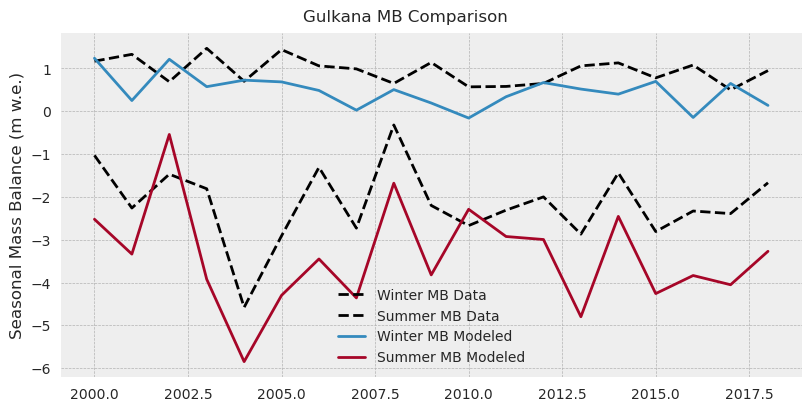

In [2]:
# Load in the data and get the dates available for the model run
# base_fn = '~/research/Output/EB/Gulkana_2024_02_08_0.nc' # good base run
base_fn = '~/research/Output/EB/Gulkana_2024_03_04_base.nc'
output_fn = '~/research/Output/EB/Gulkana_2024_03_04_nodrydep.nc'
ds_base,_,_ = getds(base_fn)
ds,startdate,enddate= getds(output_fn)
bin = 0
stake_df = pd.read_csv('~/research/MB_data/Stakes/gulkanaAB23.csv') # _GNSSIR
stake_df = stake_df.set_index(pd.to_datetime(stake_df['Date']))
temp_df = pd.read_csv('~/research/MB_data/Gulkana/field_data/iButton_2023_all.csv')
AWS_df = pd.read_csv('~/research/climate_data/AWS/Preprocessed/gulkanaD/gulkana_merra2.csv')

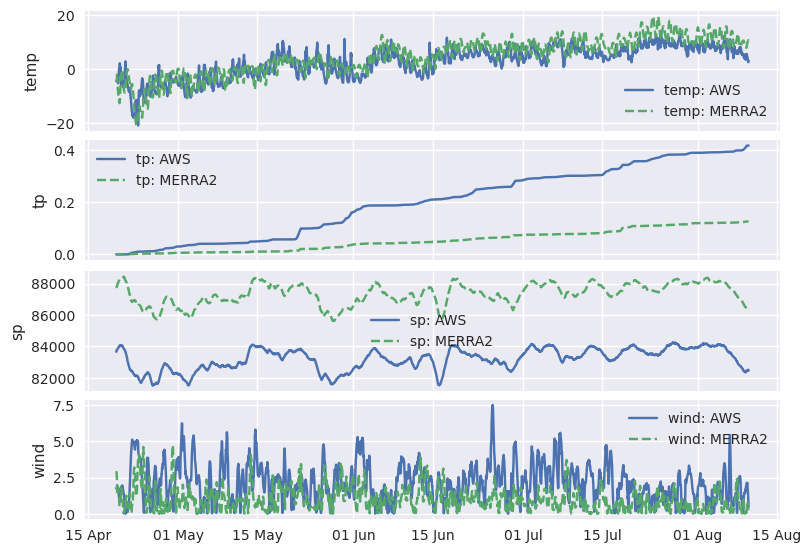

In [81]:
df_old = pd.read_csv('~/research/climate_data/AWS/Preprocessed/gulkanaD/gulkana_merra2.csv')
df_old = df_old.set_index(df_old['Datetime'])
df_merra = pd.read_csv('~/research/climate_data/AWS/Preprocessed/gulkana/gulkana_all_merra2.csv')
df_merra = df_merra.set_index(df_old['Datetime'])

compare_AWS([df_old,df_merra],['temp','tp','sp','wind'],df_old.index,['AWS','MERRA2'])

In [19]:
switches = ['000','010','001','110','020','021','120','121']
fp = '/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_02_02_'
ds_list = []
label_list = []
for switch in switches:
    ds,_,_ = getds(fp+switch+'.nc')
    ds_list.append(ds)
    label_list.append(switch)

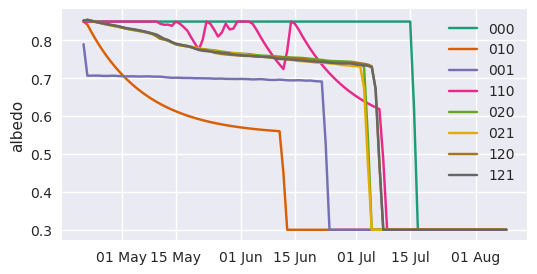

In [20]:
compare_runs(ds_list,[startdate,enddate],label_list,'albedo')

In [15]:
param_options = {
          'lapserate':{'options':[-0.003,-0.01],'value':-0.0065,'units':'K m-1'},
          'k_ice':{'options':[1.5,3],'value':2.33,'units':'W K-1 m-1'},
          'precgrad':{'options':[5e-6,5e-4],'value':0.0001,'units':''},
          'kp':{'options':[0.5,2],'value':1,'units':''},
          'albedo_ice':{'options':[0.2,0.4],'value':0.3,'units':''},
          'roughness_ice':{'options':[0.5,3],'value':1.7,'units':'mm'},
          'ksp_BC':{'options':[0.01,0.8],'value':0.1,'units':'kg kg-1'},
          'ksp_dust':{'options':[0.001,0.08],'value':0.015,'units':'kg kg-1'},
          'dz_toplayer':{'options':[0.01,0.05],'value':0.03,'units':'m'},
          'layer_growth':{'options':[0.6,0.9],'value':0.6,'units':''},
          'roughness_aging_rate':{'options':[0.04,0.08],'value':0.06267,'units':'mm d-1'},
          'dry_metamorphism_rate':{'options':[1e-5,1e-4],'value':3.5e-5,'units':'um s-1'}
          }
filename = '/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_03_13_VAR_VALUE.nc'

ds_dict = {}
for key in list(param_options.keys()):
    for value in param_options[key]['options']:
        fn = filename.replace('VAR',key).replace('VALUE',str(value))
        ds,startdate,enddate = getds(fn)
        ds_dict[key+'='+str(value)] = ds

# ds,startdate,enddate = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_22_0.nc')
# ds_dict['LAPbins=yes'] = ds
# ds,startdate,enddate = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_22_noLAPbins.nc')
# ds_dict['LAPbins=no'] = ds

Date
2023-04-18    217.98
2023-04-19    217.63
2023-04-20    217.11
2023-04-21    215.82
2023-04-22    215.11
               ...  
2023-08-19      0.00
2023-08-20      0.00
2023-08-21      0.00
2023-08-22      0.00
2023-08-23      0.00
Name: snow_depth, Length: 128, dtype: float64


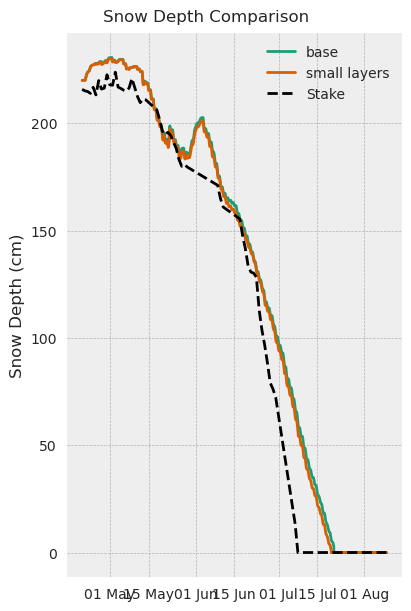

In [25]:
ds_base,_,_ = getds('~/research/Output/EB/Gulkana_2024_03_13_BASE.nc')
ds_small,_,_ = getds('~/research/Output/EB/Gulkana_2024_03_13_2.nc')
plot_stake_dh(stake_df,[ds_base,ds_small],[startdate,enddate],['base','small layers'])
plot_stake_snowdepth(stake_df,[ds_base,ds_small],[startdate,enddate],['base','small layers'])

/home/claire/research/PyGEM-EB/pygem_eb/processing/plotting_fxns.py:436: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


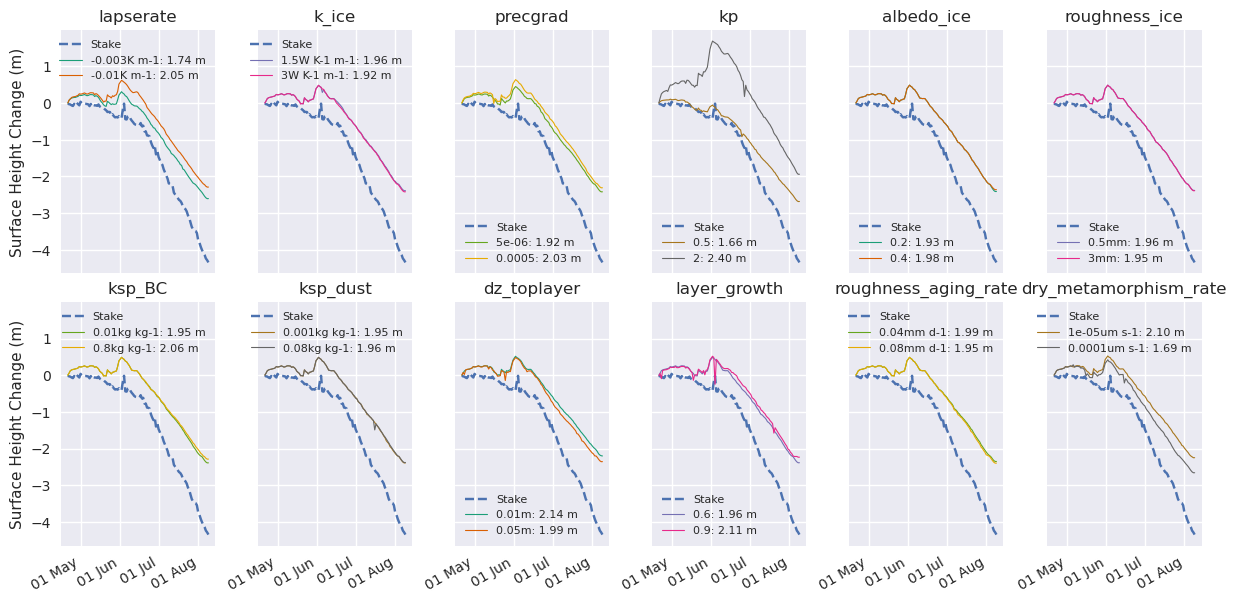

In [19]:
ds_list = list(ds_dict.values())
labels = list(ds_dict.keys())
stake_df = pd.read_csv('~/research/MB_data/Stakes/gulkanaAB23_GNSSIR.csv')
stake_df = stake_df.set_index(pd.to_datetime(stake_df['Date']))
units = [param_options[label.split('=')[0]]['units'] for label in labels]
panel_dh_compare(ds_list,[startdate,enddate],labels,units,stake_df)

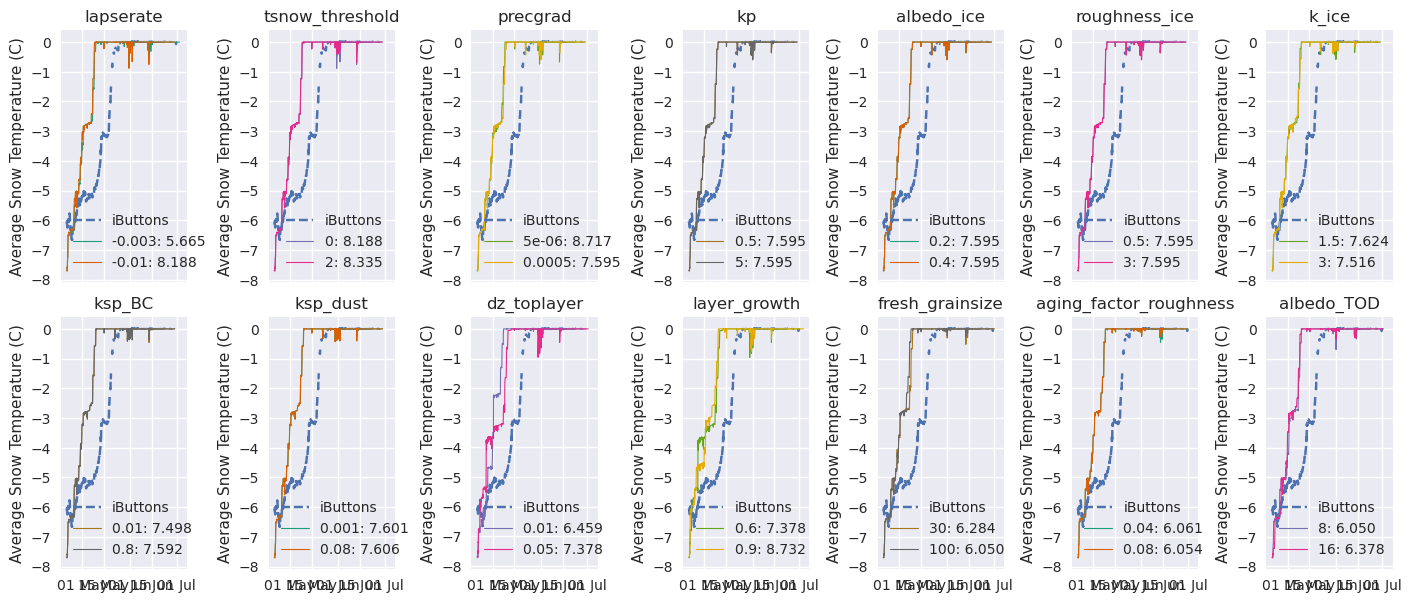

In [50]:
ds_list = list(ds_dict.values())
labels = list(ds_dict.keys())
panel_temp_compare(ds_list,[startdate,enddate],labels,temp_df)

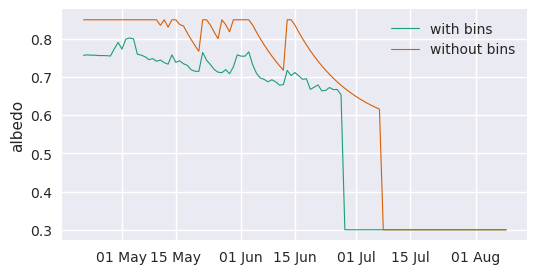

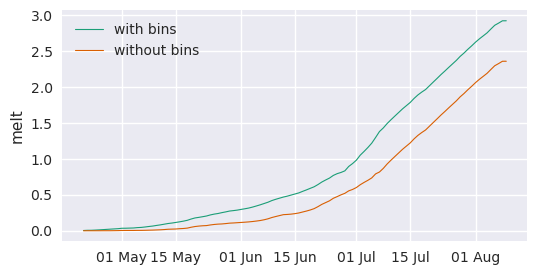

In [117]:
ds_base,startdate,enddate = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_22_0.nc')
ds_nolapbins,_,_ = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_22_noLAPbins.nc')
# ds__,_,_ = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_11_noLAPbins1.nc')
# ds_list = list(ds_dict.values())[0:5]
# labels = list(ds_dict.keys())[0:5]
compare_runs([ds_base,ds_nolapbins],[startdate,enddate],['with bins','without bins'],'albedo')
compare_runs([ds_base,ds_nolapbins],[startdate,enddate],['with bins','without bins'],'melt')

0 1
0 1


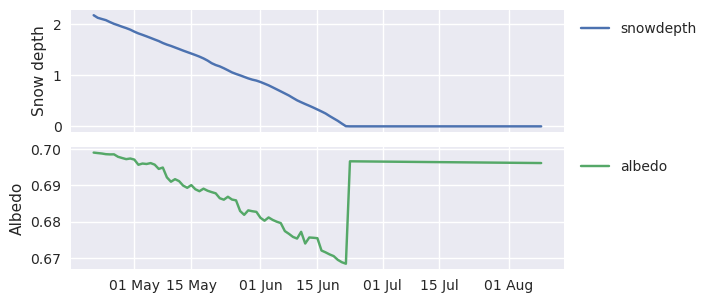

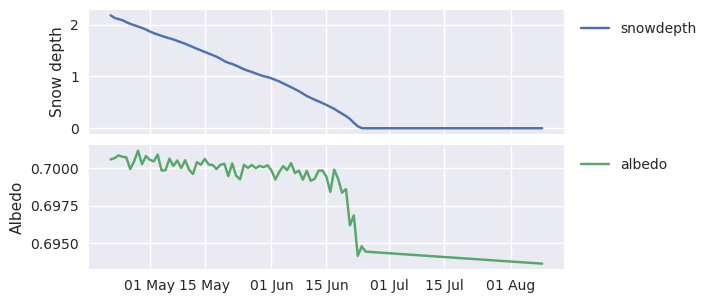

In [25]:
simple_plot(ds,0,[startdate,enddate],
            [['snowdepth'],['albedo']],
            t = '',
            skinny = True,
            new_y='accum',
            save_fig=False)
simple_plot(ds3,0,[startdate,enddate],
            [['snowdepth'],['albedo']],
            t = '',
            skinny = True,
            new_y='accum',
            save_fig=False)
print(ds.attrs['switch_melt'],ds.attrs['switch_LAPs'])
print(ds3.attrs['switch_melt'],ds3.attrs['switch_LAPs'])

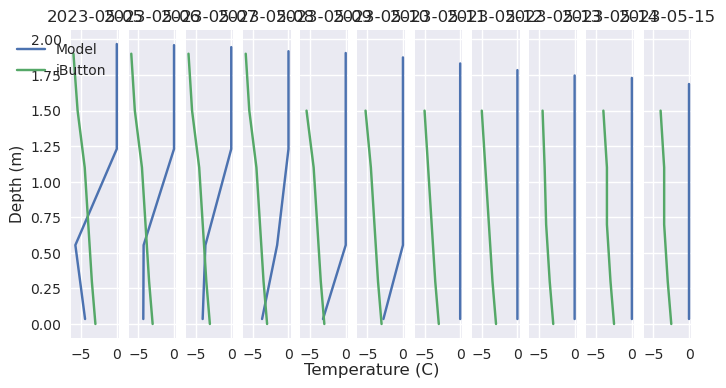

In [29]:
plot_iButtons(list(ds_list)[16],0,pd.date_range('05-05-2023 00:00','05-15-2023 00:00',freq='d'))

In [2]:
fp = '/home/claire/research/climate_data/AWS/Raw/on-Glacier/Zongo_surglacier_yrs.xlsx'
yrs = ['0405','0506','0607','0708','0809','0910','1011','1112','1213','1314','1415','1516','1617','1718','1819']
for yr in yrs:
    df = pd.read_excel(fp.replace('yrs',yr))
    if yr in ['0405']:
        df_all = df
    else:
        df_all = pd.concat([df_all,df])
print(df_all)

                                                SAMA Unnamed: 1  \
0                            Centrale Campbell CR10X        NaN   
1                    Programme : SAMA1_ORE_ZONGO.CR1        NaN   
2                                 Table : 30 minutes        NaN   
3                                   Glacier du Zongo        NaN   
4      Station météorologique "sur glacier" à 5050 m        NaN   
...                                              ...        ...   
35044                            2019-08-31 22:45:00          0   
35045                            2019-08-31 23:00:00          0   
35046                            2019-08-31 23:15:00          0   
35047                            2019-08-31 23:30:00          0   
35048                            2019-08-31 23:45:00          0   

               Année 2004-2005 Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6  \
0      GLACIOCLIM (IRD - UMSA)        NaN        NaN        NaN        NaN   
1                          NaN        N